In [3]:
import math
import numpy as np
import json
import pandas as pd
import glob

from src.constants import OUTPUTS_DIR

In [4]:
experiment_file = OUTPUTS_DIR / "estimate_effect_of_interleaver_conditional_entropy_turboae.json"

In [5]:
with open(experiment_file, "r") as e:
    results = json.load(e)

exp_results = pd.DataFrame([{**d["results"], **d["preamble"]["args"], "interleaver": "interleaver" in d["preamble"] }for d in results["data"]])

snr_vals = [2.0]
exp_results = exp_results[exp_results["snr"].isin(snr_vals)]
exp_results = exp_results[["ce__mean", "ce__err", "block_len", "encoder_name", "snr", "interleaver"]]

In [6]:
exp_results.head()

,ce__mean,ce__err,block_len,encoder_name,snr,interleaver
0,0.008803,0.000267,11,turboae_exact_nobd,2.0,True
1,0.024299,0.000374,11,turboae_exact_nobd,2.0,False
2,0.008011,0.000200,14,turboae_exact_nobd,2.0,True
3,0.019942,0.000310,14,turboae_exact_nobd,2.0,False
4,0.003623,0.000296,16,turboae_exact_nobd,2.0,True


/tmp/ipykernel_28184/1826766353.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


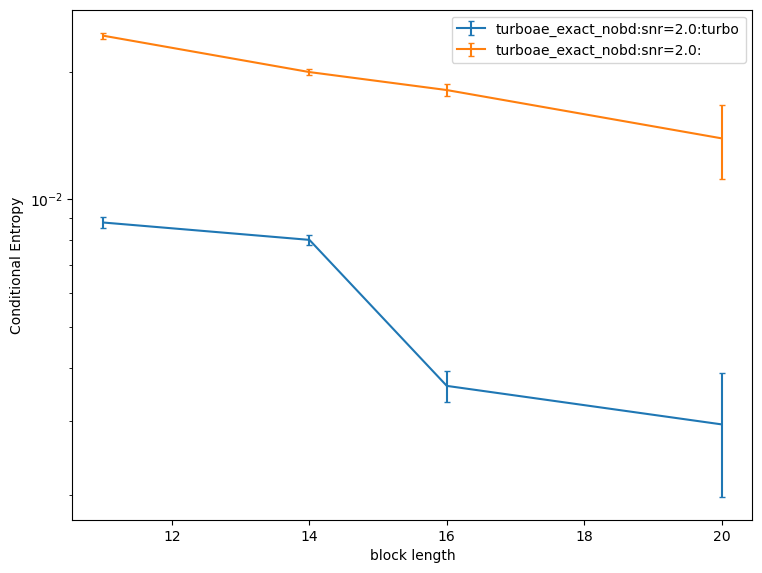

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
capsize = 2

def final_ce(group):
    (encoder_name, snr, is_turbo), exp_result = group
    return exp_result.sort_values("block_len")["ce__mean"].iloc[-1]

num_turbo = 6
num_conv = 6
count_turbo = 0
count_conv = 0

for (encoder_name, snr, is_turbo), exp_result in sorted(exp_results.groupby(["encoder_name", "snr", "interleaver"]), key=final_ce):
    if is_turbo :
        if count_turbo >= num_turbo:
            continue
        else:
            count_turbo += 1
    else:
        if count_conv >= num_conv:
            continue
        else:
            count_conv += 1
    
    ax.errorbar(
        exp_result["block_len"], 
        exp_result["ce__mean"], 
        yerr=exp_result["ce__err"], 
        linestyle='-',
        capsize=capsize,
        label=f"{encoder_name}:snr={snr}:{'turbo' if is_turbo else ''}"
    )
ax.legend()
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('block length')
ax.set_ylabel('Conditional Entropy')

fig.show()

In [8]:
res = sorted(exp_results.groupby(["encoder_name", "snr", "interleaver"]), key=final_ce)[0][1]
res_16 = res[res["block_len"] == 16]
res_16

,ce__mean,ce__err,block_len,encoder_name,snr,interleaver
4,0.003623,0.000296,16,turboae_exact_nobd,2.0,True


In [9]:
experiment_file_1 = OUTPUTS_DIR / "train_turbo_table.json"
experiment_file_2 = OUTPUTS_DIR / "train_turbo_table_2.json"
experiment_file_3 = OUTPUTS_DIR / "train_turbo_table_3.json"
experiment_file_4 =OUTPUTS_DIR / "train_turbo_table_init_method.json"
experiment_file_5 =OUTPUTS_DIR / "train_turbo_table_fourier_lr_search.json"
experiment_file_6 =OUTPUTS_DIR / "train_turbo_table_fourier_get_trajectory.json"


exp_files = [experiment_file_1, experiment_file_2, experiment_file_3,experiment_file_4, experiment_file_5, experiment_file_6]

In [10]:
training_runs = []
validation_runs = []
for exp_file in exp_files:
    with open(exp_file, "r") as e:
        results = json.load(e)
    for d in results["data"]:
        if "results" not in d:
            continue
            
        training_results = pd.DataFrame([res for res in d["results"] if res["type"] == "training"])
        validation_results = pd.DataFrame([{**res, "step": (d["results"][i-1]["step"] + 1 if i > 0 else 0)} for i, res in enumerate(d["results"]) if res["type"] == "validation"])
        preambles = pd.DataFrame([{**d["preamble"]["args"], **d["preamble"]}])
        print(preambles.columns)
        training_results = training_results.merge(preambles, how="cross")
        validation_results = validation_results.merge(preambles, how="cross")
        
        
        training_runs.append(training_results)
        validation_runs.append(validation_results)

training = pd.concat(training_runs, axis=0)
validation = pd.concat(validation_runs, axis=0)

arg_select_cols = ["adam_lr", "block_len", "window", "snr", "init_method", "argument_hash"]
training_select_cols = ["xe", "ce", "ber", "bler", "step", "noninterleaved_encoder.table_grad_l2", "interleaved_encoder.table_grad_l2"] + (["true_ber"] if "true_ber" in training.columns else [])
val_select_cols = ["xe__mean", "ce__mean", "ber__mean", "bler__mean", "xe__err", "ce__err", "ber__err", "bler__err", "step", ] + (["true_ber__mean, true_ber__err"] if "true_ber" in validation.columns else [])

training = training[training_select_cols + arg_select_cols]
validation = validation[val_select_cols + arg_select_cols]

display(training.head())
display(validation.head())

Index(['block_len', 'interleaver_base_seed', 'batch_size', 'snr', 'num_steps',
       'num_validation_steps', 'adam_lr', 'delay', 'window',
       'num_noninterleaved_streams', 'num_interleaved_streams',
       'use_inputs_for_loss', 'save_every', 'output_dir', 'args', 'encoder',
       'channel', 'output_path', 'argument_hash'],
      dtype='object')
Index(['block_len', 'interleaver_base_seed', 'batch_size', 'snr', 'num_steps',
       'num_validation_steps', 'adam_lr', 'delay', 'window',
       'num_noninterleaved_streams', 'num_interleaved_streams',
       'use_inputs_for_loss', 'save_every', 'output_dir', 'args', 'encoder',
       'channel', 'output_path', 'argument_hash'],
      dtype='object')
Index(['block_len', 'interleaver_base_seed', 'batch_size', 'snr', 'num_steps',
       'num_validation_steps', 'adam_lr', 'delay', 'window',
       'num_noninterleaved_streams', 'num_interleaved_streams',
       'use_inputs_for_loss', 'save_every', 'output_dir', 'args', 'encoder',
       'cha

,xe,ce,ber,bler,step,noninterleaved_encoder.table_grad_l2,interleaved_encoder.table_grad_l2,true_ber,adam_lr,block_len,window,snr,init_method,argument_hash
0,0.068559,0.108907,0.026204,0.203125,0,0.031143,0.021050,NaN,10.0,16,5,1.0,NaN,06f15f737c774313b7517478e386065595cf79b3
1,0.026480,0.048298,0.010091,0.109375,1,0.001237,0.000869,NaN,10.0,16,5,1.0,NaN,06f15f737c774313b7517478e386065595cf79b3
2,0.023140,0.046817,0.007812,0.059896,2,0.000920,0.000873,NaN,10.0,16,5,1.0,NaN,06f15f737c774313b7517478e386065595cf79b3
3,0.028507,0.042780,0.010091,0.098958,3,0.000691,0.000392,NaN,10.0,16,5,1.0,NaN,06f15f737c774313b7517478e386065595cf79b3
4,0.023659,0.039878,0.008789,0.083333,4,0.000522,0.000390,NaN,10.0,16,5,1.0,NaN,06f15f737c774313b7517478e386065595cf79b3


,xe__mean,ce__mean,ber__mean,bler__mean,xe__err,ce__err,ber__err,bler__err,step,adam_lr,block_len,window,snr,init_method,argument_hash
0,0.073232,0.107710,0.029834,0.218490,0.005257,0.004798,0.002483,0.013338,0,10.0,16,5,1.0,NaN,06f15f737c774313b7517478e386065595cf79b3
1,0.019159,0.028806,0.007292,0.052344,0.002756,0.002384,0.001432,0.007189,50,10.0,16,5,1.0,NaN,06f15f737c774313b7517478e386065595cf79b3
0,0.046395,0.064242,0.017448,0.103125,0.005349,0.003926,0.002256,0.009817,0,10.0,16,9,1.0,NaN,c3d6706325afa2c101710871ff6f22cde32ab128
1,0.019382,0.024437,0.006559,0.041927,0.003901,0.002323,0.001409,0.006469,50,10.0,16,9,1.0,NaN,c3d6706325afa2c101710871ff6f22cde32ab128
0,0.058033,0.085407,0.021712,0.182813,0.004672,0.003712,0.002030,0.012476,0,10.0,16,5,1.0,NaN,1a8ecf810709ecffaa21267b9e766930ce2963af


w=5:init=fourier_normal
9ba0bf5abe79a80158a8cb9caef681e01d8b3b81
0    0.037713
1    0.035218
2    0.032023
3    0.029206
4    0.027668
5    0.026594
6    0.024163
Name: ce__mean, dtype: float64
w=5:init=fourier_normal
db19ded0522355346cbfeec1adcdff17ac975e8f
0    0.038269
1    0.007206
2    0.005322
3    0.004312
4    0.004197
5    0.004033
6    0.004131
Name: ce__mean, dtype: float64
w=5:init=binary
e5ab48f46450ac63d91b1e31a45c8b3181f98f72
0     0.028565
1     0.004868
2     0.004367
3     0.004369
4     0.003731
5     0.003238
6     0.003065
7     0.003541
8     0.003267
9     0.003008
10    0.003847
Name: ce__mean, dtype: float64
w=5:init=fourier_normal
ef3c698107aac0f864563e6716d0abfd1b3962f7
0    0.033061
1    0.006012
2    0.005752
3    0.005553
4    0.007369
5    0.005535
6    0.008880
Name: ce__mean, dtype: float64
w=5:init=normal
a41b2d3ea9d8c5d3a416276e860fbf801be4bafc
0     0.044407
1     0.006410
2     0.004770
3     0.004603
4     0.004126
5     0.005037
6     0.003622
7  

/tmp/ipykernel_28184/575442424.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_28184/575442424.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_28184/575442424.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_28184/575442424.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_28184/575442424.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_28184/575442424.py:56: Us

w=9:init=parity
f00f34a22eeefceb5a784643c673752bdcbd865c
0     0.006572
1     0.004874
2     0.004635
3     0.005236
4     0.003853
5     0.004288
6     0.004001
7     0.003046
8     0.002890
9     0.003737
10    0.003433
Name: ce__mean, dtype: float64


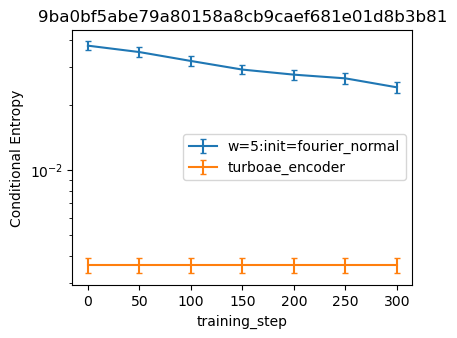

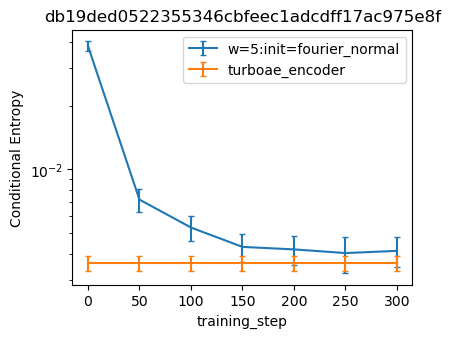

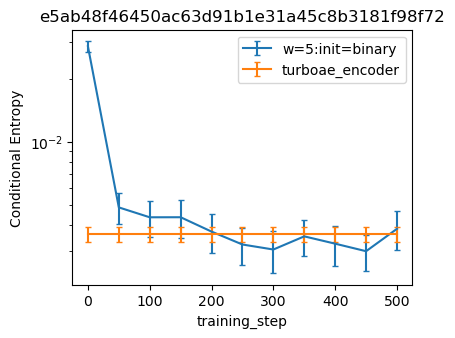

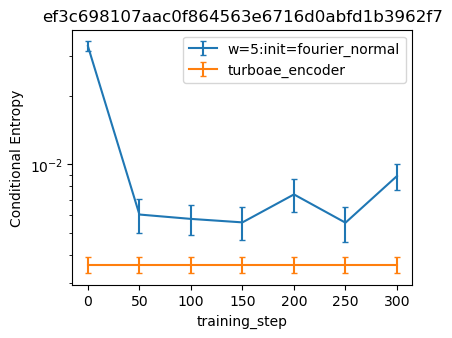

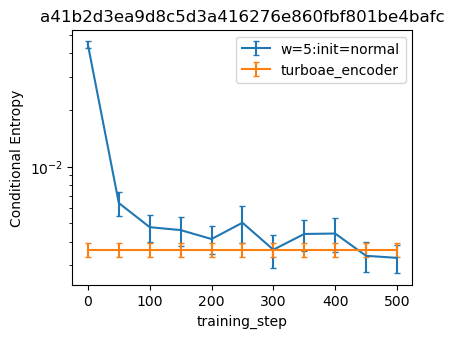

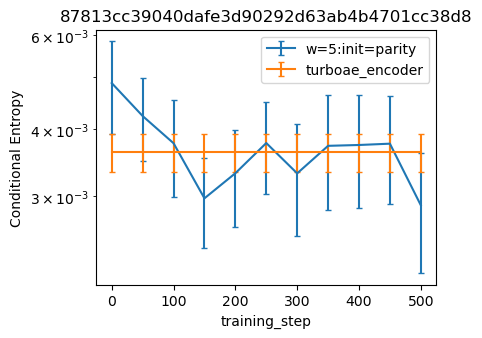

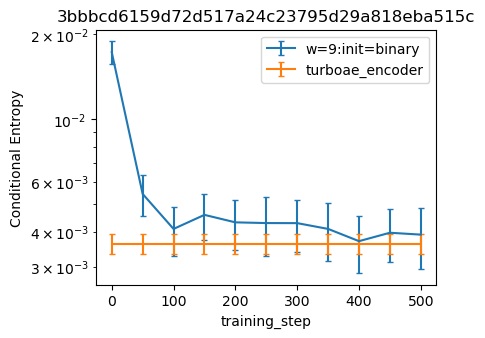

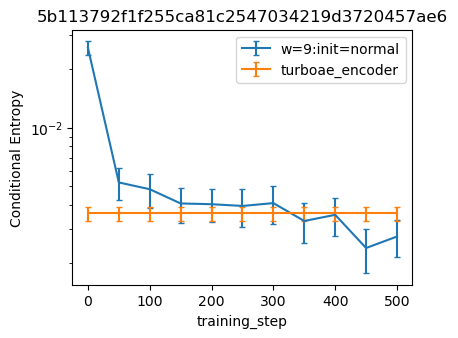

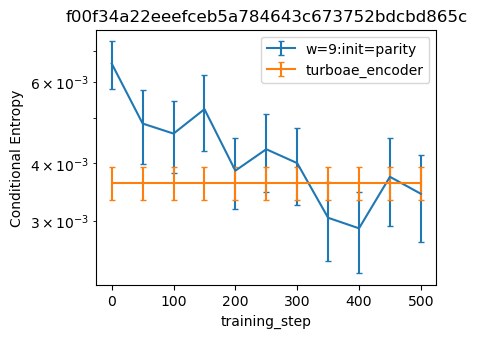

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# fig = plt.figure(figsize=(8, 6), dpi=100)
# ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
# capsize = 2

# for (snr, decoder_type, enc_name), exp_result in exp_results.groupby(["snr", "decoder_type", "encoder_name"]):
#     ax.errorbar(
#         exp_result["block_len"][:10], 
#         exp_result["xe__mean"][:10], 
#         yerr=exp_result["xe__err"][:10], 
#         linestyle='-',
#         capsize=capsize,
#         label=f"{enc_name}:{decoder_type}:snr={snr}"
#     )

for (lr, block_len, window, snr, init_method, argument_hash), validation_result in validation.groupby(["adam_lr", "block_len", "window", "snr", "init_method", "argument_hash"]):
    if np.count_nonzero(validation_result["ce__mean"].notna()) < 3:
        continue
    fig = plt.figure(figsize=(4, 3), dpi=100)
    ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
    capsize = 2
    label=f"w={window}:init={init_method}"
    
    print("=====================")
    print(label)
    print(argument_hash)
    print(validation_result["ce__mean"])
    
    ax.errorbar(
        validation_result["step"], 
        validation_result["ce__mean"], 
        yerr=validation_result["ce__err"], 
        linestyle='-',
        capsize=capsize,
        label=label
    )
    bds = pd.merge(validation_result["step"], res_16, how="cross")
    ax.errorbar(
        bds["step"], 
        bds["ce__mean"], 
        yerr=bds["ce__err"], 
        linestyle='-',
        capsize=capsize,
        label=f"turboae_encoder"
    )
    ax.legend()
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_title(argument_hash)
    ax.set_xlabel('training_step')
    ax.set_ylabel('Conditional Entropy')

    fig.show()

9ba0bf5abe79a80158a8cb9caef681e01d8b3b81
db19ded0522355346cbfeec1adcdff17ac975e8f
e456e390bff5fabe66798bbccc2785d178a50ef4
e5ab48f46450ac63d91b1e31a45c8b3181f98f72
ef3c698107aac0f864563e6716d0abfd1b3962f7
a41b2d3ea9d8c5d3a416276e860fbf801be4bafc
87813cc39040dafe3d90292d63ab4b4701cc38d8


/tmp/ipykernel_28184/963316947.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_28184/963316947.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_28184/963316947.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_28184/963316947.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_28184/963316947.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_28184/963316947.py:51: Us

3bbbcd6159d72d517a24c23795d29a818eba515c
5b113792f1f255ca81c2547034219d3720457ae6
f00f34a22eeefceb5a784643c673752bdcbd865c


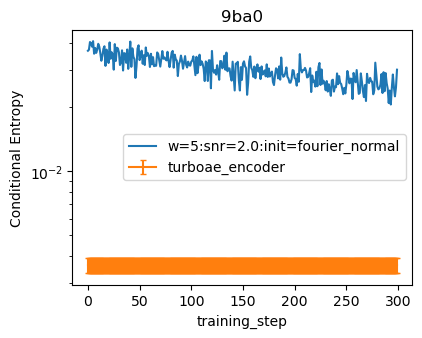

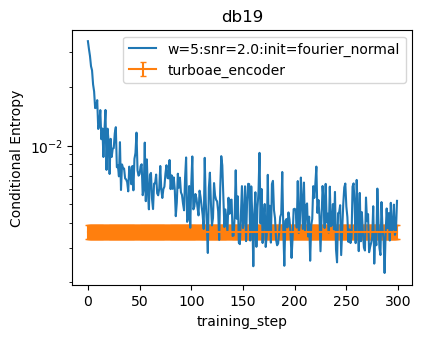

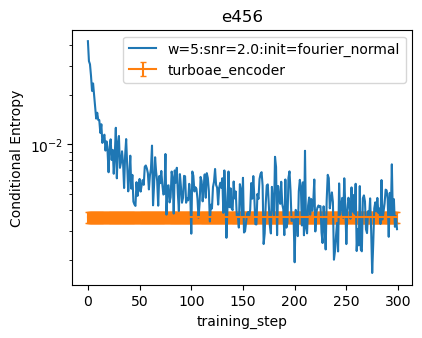

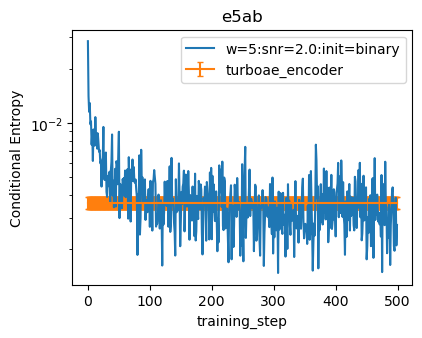

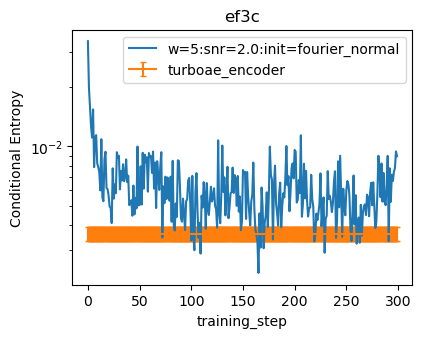

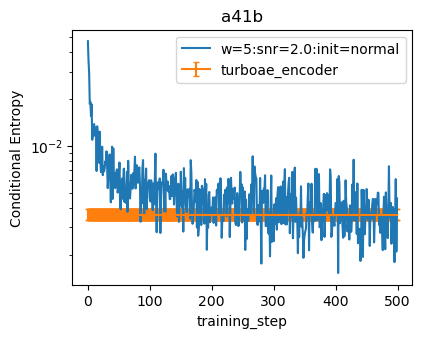

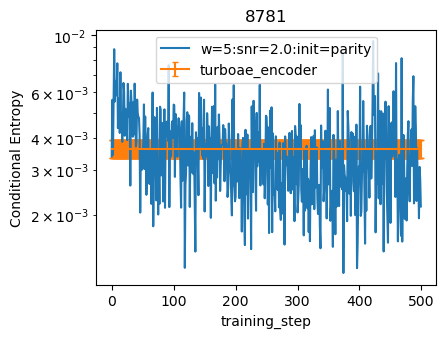

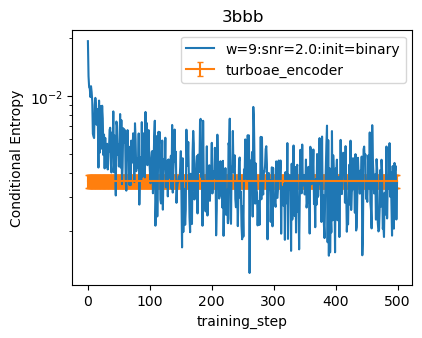

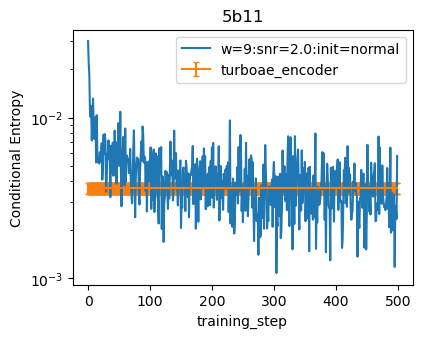

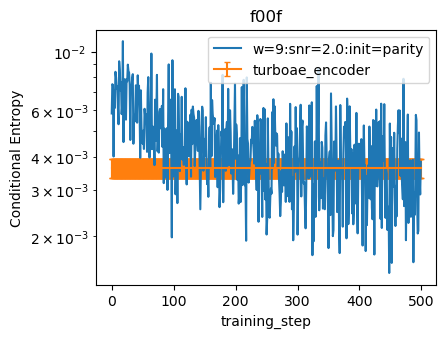

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# fig = plt.figure(figsize=(8, 6), dpi=100)
# ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
# capsize = 2

# for (snr, decoder_type, enc_name), exp_result in exp_results.groupby(["snr", "decoder_type", "encoder_name"]):
#     ax.errorbar(
#         exp_result["block_len"][:10], 
#         exp_result["xe__mean"][:10], 
#         yerr=exp_result["xe__err"][:10], 
#         linestyle='-',
#         capsize=capsize,
#         label=f"{enc_name}:{decoder_type}:snr={snr}"
#     )

for (lr, block_len, window, snr, init_method, argument_hash), training_result in training.groupby(["adam_lr", "block_len", "window", "snr", "init_method", "argument_hash"]):
    if len(training_result) < 100:
        continue
    
    fig = plt.figure(figsize=(4, 3), dpi=100)
    ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
    capsize = 2
    print(argument_hash)
    ax.errorbar(
        training_result["step"], 
        training_result["ce"], 
        # yerr=exp_result["xe__err"], 
        linestyle='-',
        capsize=capsize,
        label=f"w={window}:snr={snr}:init={init_method}"
    )
    bds = pd.merge(training_result["step"], res_16, how="cross")
    ax.errorbar(
        bds["step"], 
        bds["ce__mean"], 
        yerr=bds["ce__err"], 
        linestyle='-',
        capsize=capsize,
        label=f"turboae_encoder"
    )
    ax.legend()
    ax.set_title(argument_hash[:4])
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_xlabel('training_step')
    ax.set_ylabel('Conditional Entropy')

    fig.show()